In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
from matplotlib import pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")



###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir)
yielddatadirectory=directory+"/data/yielddata/cpibonddefiniton.csv"
marketdatadirectory=directory+"/data/marketdata/marketdata.csv"
inflationdatadirectory=directory+"/data/inflationdata/inflationdata.csv"
realratedatadirectory=directory+"/data/marketdata/realrate.csv"


bonddefiniton = pd.read_csv(yielddatadirectory)
marketdata = pd.read_csv(marketdatadirectory)
inflationdata = pd.read_csv(inflationdatadirectory)
realrate = pd.read_csv(realratedatadirectory)


yielddata=bonddefiniton.merge(marketdata[['valuationDate','isinCode','value']], left_on='isinCode', right_on='isinCode')
realdata=yielddata.merge(realrate[['valuationDate','isinCode','yield']], left_on=['valuationDate','isinCode'], right_on=['valuationDate','isinCode'])

yielddata = realdata.replace(np.nan, '', regex=True) 
yielddata=yielddata[yielddata["valuationDate"]=="2022-01-13"]

In [2]:
data = {
  "valuationDate": "2022-01-13",
  #"baseRate": 0.01,
  "inflationCurve": {
    "settlementDays": 2,
    "intpMethod": "Linear",
    "currency": "TRY",
    "calendar": "TARGET",
    "dayCounter": "ActualActual",
    "period": "",
    "instruments": {
      "CPIBOND": {
        "settlementDays": 2,
        "observationLag": "3M",
      }
    },
    "inflationIndex": {
      "indexName": "TRCPI",
      "index": "ZC",
      "interpolated": True
    }
  },
  "yieldData": yielddata.to_dict('r'),
  "inflationData": inflationdata.to_dict('r')
}

try:
    result = api.createTask(CalculationType.INFLATION_CURVE, data,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [3]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovayieldcurvedicts = {}
rhoovayieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovayieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovayieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

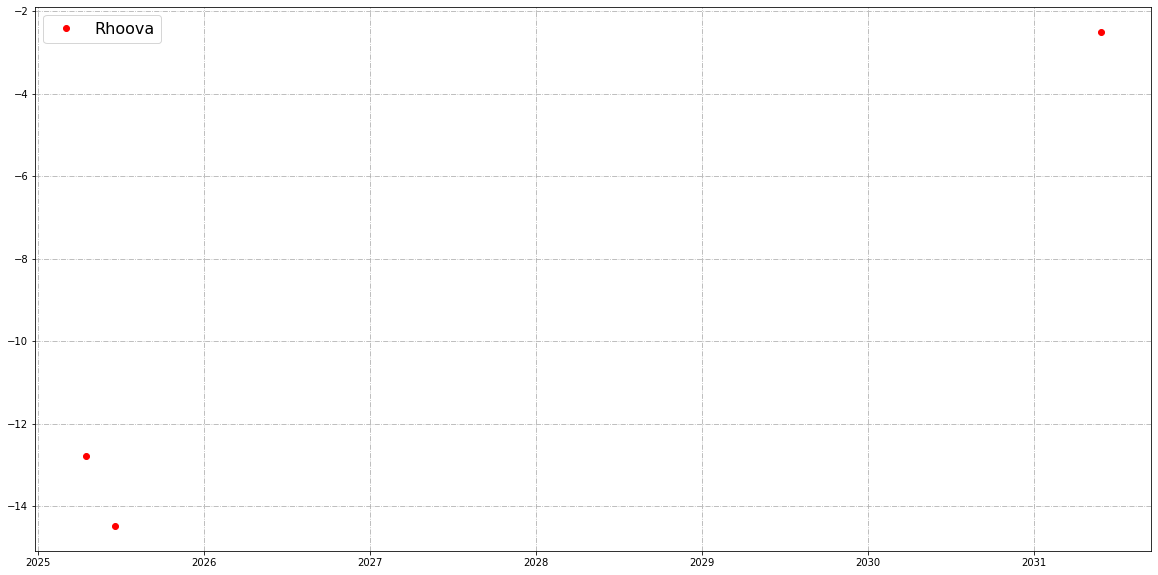

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y = list(rhoovayieldcurvedicts.values())


ax.plot(x,y, 'ro', label='Rhoova', linewidth=4)
#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

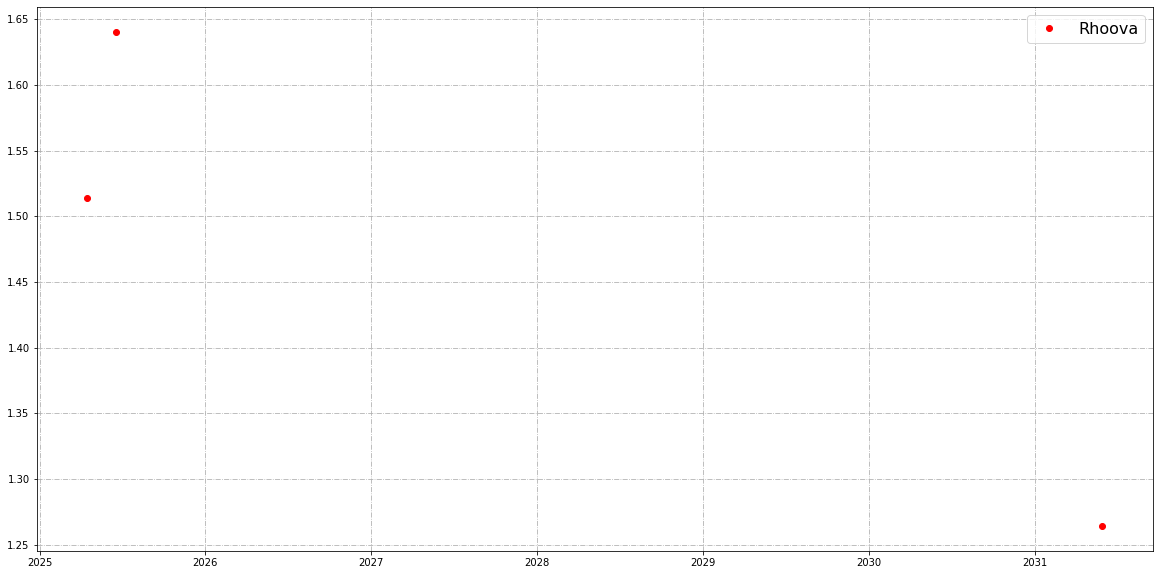

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y = list(rhoovayieldcurvediscounts.values())

ax.plot(x,y, 'ro', label='Rhoova', linewidth=12)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()